In [134]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
from sklearn import metrics
import scipy.stats as ss
import copy

import warnings

warnings.simplefilter('ignore')

In [4]:
# load data first
file_path = 'C:/Users/guangqiiang.lu/Downloads/model-asset/xgboost'
file_name = [x for x in os.listdir(file_path) if x.endswith('npy') ][0]

data = np.load(os.path.join(file_path, file_name), allow_pickle=True)

data_column = ['Supplier Name              ', 'Supplier Num', 'Supplier Type',
               'Supplier Site', 'Operating Unit', 'Invoice Date', 'Invoice Number',
               'Invoice Amount', 'Invoice Currency', 'Discount Amount',
               'Payment Amount', 'Payment Currency', 'Payment Document Name',
               'Payment Method', 'Pay Group', 'Document Number', 'Payment Date',
               'FileName', 'Company Code', 'Exchange Rate', 'invoice Exchange Rate',
               'Payment AmountUSD', 'invoice AmountUSD', 'Vendor Category',
               'Trade Type', 'Month end day', 'Scope', 'DTP', 'Weighted DTP Value',
               'KeyMaster', 'Working Capital Impact', 'Pay Term', 'Invoice Type',
               'Net Due Date', 'Aging', 'Payment Category', 'Weighted Aging Value',
               'Payment Term Days', 'P&L Impact', 'Late Pay Range']

data = pd.DataFrame(data, columns=data_column)

# get samples
data.head()

,Supplier Name,Supplier Num,Supplier Type,Supplier Site,Operating Unit,Invoice Date,Invoice Number,Invoice Amount,Invoice Currency,Discount Amount,...,Working Capital Impact,Pay Term,Invoice Type,Net Due Date,Aging,Payment Category,Weighted Aging Value,Payment Term Days,P&L Impact,Late Pay Range
0,bingologistics (shanghai）Co. Ltd.,10826,NONTRADE,CNCNYNTRCN1A,"ARROW(CHINA)ELECTRONICSTRADINGCO.,LTD.",2017-11-08,07000677-07000679,235090,CNY,0,...,35610,NET_45,STANDARD,2017-12-23,-30,Early Payment,-1.0683e+06,45,-234.148,<10%
1,"shanghai aiconb Technology Co., Ltd.",10902,NONTRADE,CNCNYNTRCN1,"ARROW(CHINA)ELECTRONICSTRADINGCO.,LTD.",2017-06-08,5093620,6450,CNY,0,...,951.201,NET_45,STANDARD,2017-07-23,-31,Early Payment,-29487.2,45,-6.46296,<10%
2,shouxiafeng,10815,NONTRADE,CNCNYNTRCN1,"ARROW(CHINA)ELECTRONICSTRADINGCO.,LTD.",2017-04-06,14378087,25000,CNY,0,...,3686.83,NET_45,STANDARD,2017-05-21,32,Late Payment,117978,45,25.8583,50%+
3,shouxiafeng,10815,NONTRADE,CNCNYNTRCN1,"ARROW(CHINA)ELECTRONICSTRADINGCO.,LTD.",2017-10-10,14378100,25000,CNY,0,...,3842.13,NET_45,STANDARD,2017-11-24,27,Late Payment,103738,45,22.737,50%+
4,wanda jiecheng International Logistics (Beijin...,10800,NONTRADE,CNCNYNTRCN1,"ARROW(CHINA)ELECTRONICSTRADINGCO.,LTD.",2017-12-05,18354393,66495.1,CNY,0,...,10219.3,NET_45,STANDARD,2018-01-19,-29,Early Payment,-296360,45,-64.9557,<10%


In [12]:
# load other resource file
mapping_file = [x for x in os.listdir(file_path) if 'mapping' in x][0]
pmi_file = [x for x in os.listdir(file_path) if 'pmi' in x.lower()][0]

mapping = pd.read_excel(os.path.join(file_path, mapping_file), encoding='utf-8')
data_pmi = pd.read_excel(os.path.join(file_path, pmi_file), encoding='utf-8')

In [13]:
# mapping data, this is for vacation info
mapping.head()

,date,weekday,holiday,day after vacation,day after vacation days,special vacation,quarter,month of quarter,week of month
0,2017-01-01,7,1,0,0,0,1,1,1
1,2017-01-02,1,1,0,0,0,1,1,1
2,2017-01-03,2,0,1,2,1,1,1,1
3,2017-01-04,3,0,0,0,0,1,1,1
4,2017-01-05,4,0,0,0,0,1,1,1


In [14]:
# pmi data, this is other useful information
data_pmi.head()

,月份,制造业PMI,制造业同比增长,非制造业PMI,非制造业同比,非制造业环比
0,2020-04-01,50.8,0.0140,53.2,-0.0203,0.017208
1,2020-03-01,52.0,0.0297,52.3,-0.0456,0.766892
2,2020-02-01,35.7,-0.2744,29.6,-0.4549,-0.452865
3,2020-01-01,50.0,0.0101,54.1,-0.0110,0.011215
4,2019-12-01,50.2,0.0162,53.5,-0.0056,-0.016544


### Data transformation
筛选scope，并且计算理论的payment date

In [5]:
# filter data 
print('unique scope: ', np.unique(data['Scope']))

data_filter = data[(data['Scope'] == 'Scope In')].reset_index(drop=True)

# convert to date type
data_filter['Payment Date'] = pd.to_datetime(data_filter['Payment Date'])

# make money into float
data_filter['Payment AmountUSD'] = data_filter['Payment AmountUSD'].astype(float)

# get raw data that we need to use, 
# TODO: but why to use these columns?
rawdata = data_filter[['invoice AmountUSD','Supplier Num', 'Invoice Number','DTP', 'Trade Type','Supplier Type','Payment Date','Payment AmountUSD']]
rawdata.head()

unique scope:  ['Scope In' 'Scope Out']


,invoice AmountUSD,Supplier Num,Invoice Number,DTP,Trade Type,Supplier Type,Payment Date,Payment AmountUSD
0,35610,10826,07000677-07000679,15,NON TRADE,NONTRADE,2017-11-23,35610.000311
1,951.201,10902,5093620,14,NON TRADE,NONTRADE,2017-06-22,951.201168
2,3686.83,10815,14378087,77,NON TRADE,NONTRADE,2017-06-22,3686.826233
3,3842.13,10815,14378100,72,NON TRADE,NONTRADE,2017-12-21,3842.134382
4,10219.3,10800,18354393,16,NON TRADE,NONTRADE,2017-12-21,10219.321325


In [7]:
# what is 'Trade Type'
np.unique(rawdata['Trade Type'])

# convert "T&E" into 'TE'
rawdata['Trade Type'][rawdata['Trade Type']=="T&E"] = 'TE'


array(['INTERCOMPANY', 'NON TRADE', 'T&E', 'TRADE'], dtype=object)

### 因子的计算

In [11]:
# before get start date, what is ealiest day?
print('min date: ',min(rawdata['Payment Date']))
print('max date: ', max(rawdata['Payment Date']))

min date:  2017-05-02 00:00:00
max date:  2020-04-28 00:00:00


In [15]:
# get min date that we need to process.
# data_choose = input("please input the start date:")
data_choose = '2019-01-01'   # random set a date

# get that date after data
rawdata_choose = rawdata[rawdata['Payment Date']>=data_choose]    

# merge chosen data with mapping data, with `left` join as may not exist
rawdata_new = rawdata_choose.merge(mapping,how = 'left', left_on = ['Payment Date'], right_on = ['date'])

# add year, month, day info 
rawdata_new['y'] = rawdata_new['Payment Date'].dt.year
rawdata_new['m'] = rawdata_new['Payment Date'].dt.month
rawdata_new['d'] = rawdata_new['Payment Date'].dt.day

# let's check
rawdata_new.head()

,invoice AmountUSD,Supplier Num,Invoice Number,DTP,Trade Type,Supplier Type,Payment Date,Payment AmountUSD,date,weekday,holiday,day after vacation,day after vacation days,special vacation,quarter,month of quarter,week of month,y,m,d
0,2354.64,5831,534520191451234284-L01,17,NON TRADE,NONTRADE,2019-07-12,2354.642831,2019-07-12,5,0,0,0,0,3,1,2,2019,7,12
1,4570.83,5831,534520191451450907-L01,11,NON TRADE,NONTRADE,2019-12-06,4570.829037,2019-12-06,5,0,0,0,0,4,3,2,2019,12,6
2,70.6466,5831,534520191451266636-L01,23,NON TRADE,NONTRADE,2019-08-09,70.646598,2019-08-09,5,0,0,0,0,3,2,2,2019,8,9
3,644.073,5831,534520181451462414-L01,16,NON TRADE,NONTRADE,2019-01-11,644.073322,2019-01-11,5,0,0,0,0,1,1,2,2019,1,11
4,6136.24,5831,534520191451358540-L01,24,NON TRADE,NONTRADE,2019-10-11,6136.241401,2019-10-11,5,0,0,0,0,4,1,2,2019,10,11


In [17]:
# add other info with mpi
# which year + which quarter + 01
rawdata_new['key_pmi'] = rawdata_new['y'].astype(str)+"-"+rawdata_new['month of quarter'].astype(str)+"-"+"01"

# convert to datatime
rawdata_new['key_pmi'] = pd.to_datetime(rawdata_new['key_pmi'])

# year + quarter + month of quarter + week of month
rawdata_new['key_groupby'] = rawdata_new['y'].astype(str)+"-"+rawdata_new['quarter'].astype(str)+"-"+rawdata_new['month of quarter'].astype(str)+"-"+rawdata_new['week of month'].astype(str)

# quarter +  month of quarter + week of month
rawdata_new['key_factor'] = rawdata_new['quarter'].astype(str)+"-"+rawdata_new['month of quarter'].astype(str)+"-"+rawdata_new['week of month'].astype(str)

# check new rawdata
rawdata_new.head()


,invoice AmountUSD,Supplier Num,Invoice Number,DTP,Trade Type,Supplier Type,Payment Date,Payment AmountUSD,date,weekday,...,special vacation,quarter,month of quarter,week of month,y,m,d,key_pmi,key_groupby,key_factor
0,2354.64,5831,534520191451234284-L01,17,NON TRADE,NONTRADE,2019-07-12,2354.642831,2019-07-12,5,...,0,3,1,2,2019,7,12,2019-01-01,2019-3-1-2,3-1-2
1,4570.83,5831,534520191451450907-L01,11,NON TRADE,NONTRADE,2019-12-06,4570.829037,2019-12-06,5,...,0,4,3,2,2019,12,6,2019-03-01,2019-4-3-2,4-3-2
2,70.6466,5831,534520191451266636-L01,23,NON TRADE,NONTRADE,2019-08-09,70.646598,2019-08-09,5,...,0,3,2,2,2019,8,9,2019-02-01,2019-3-2-2,3-2-2
3,644.073,5831,534520181451462414-L01,16,NON TRADE,NONTRADE,2019-01-11,644.073322,2019-01-11,5,...,0,1,1,2,2019,1,11,2019-01-01,2019-1-1-2,1-1-2
4,6136.24,5831,534520191451358540-L01,24,NON TRADE,NONTRADE,2019-10-11,6136.241401,2019-10-11,5,...,0,4,1,2,2019,10,11,2019-01-01,2019-4-1-2,4-1-2


### 根据历史趋势添加schedule的flag/sum维度

month of quarter: 每个季度的第几个月（每个季度3个月）

week of month: 每个月的第几周

quarter： 第几个季度

In [18]:
# This is for trade
rawdata_new['schedule_trade'] = 0

# when to set with 1 flag for trade? Really amazing for the logic!!!
# 每个月的第1或2周并且是周五；或：每个季度的第3周且每个月的第4周且周五；或：不是每个季度的第3个月且每个月的第4周且周4
rawdata_new['schedule_trade'][(rawdata_new['Trade Type'] == 'Trade')&
           ((((rawdata_new['week of month']==1)|(rawdata_new['week of month']==2)) & (rawdata_new['weekday']==5))|
           ((rawdata_new['week of month']==4)&(rawdata_new['month of quarter']==3)&(rawdata_new['weekday']==5))|
           ((rawdata_new['week of month']==4)&(rawdata_new['month of quarter']!=3)&(rawdata_new['weekday']==4)))] = 1

In [19]:
# for non-trade
rawdata_new['schedule_nontrade'] = 0   

# another amazing logic
# 每个月的第2周且周5,或：每个月的第4周且每个季度的第3个月且周5；或；每个月的第4周且不是每个季度的第3个月且周4
rawdata_new['schedule_nontrade'][(rawdata_new['Trade Type'] == 'Non Trade')&
           (((rawdata_new['week of month']==2)&(rawdata_new['weekday']==5))|
           ((rawdata_new['week of month']==4)&(rawdata_new['month of quarter']==3)&(rawdata_new['weekday']==5))|
           ((rawdata_new['week of month']==4)&(rawdata_new['month of quarter']!=3)&(rawdata_new['weekday']==4)))] = 1

In [20]:
# this is for TE
rawdata_new['schedule_te'] = 0                              

# 10 或 20 号
rawdata_new['schedule_te'][(rawdata_new['Trade Type'] == 'TE')&((rawdata_new['d'] == 10)|(rawdata_new['d'] == 20))] = 1


### 根据历史添加amount/invoicenumber/suppliernumber/DTP维度,以及schedule的sum值

In [21]:
# get factor data that is before 2020-01-01
factor_train = rawdata_new[rawdata_new['date']<'2020-01-01']

# make invoice and DTP data into float
factor_train['invoice AmountUSD'] = factor_train['invoice AmountUSD'].astype(float)
factor_train['DTP'] = factor_train['DTP'].astype(float)

factor_train.head()

,invoice AmountUSD,Supplier Num,Invoice Number,DTP,Trade Type,Supplier Type,Payment Date,Payment AmountUSD,date,weekday,...,week of month,y,m,d,key_pmi,key_groupby,key_factor,schedule_trade,schedule_nontrade,schedule_te
0,2354.642831,5831,534520191451234284-L01,17.0,NON TRADE,NONTRADE,2019-07-12,2354.642831,2019-07-12,5,...,2,2019,7,12,2019-01-01,2019-3-1-2,3-1-2,0,0,0
1,4570.829037,5831,534520191451450907-L01,11.0,NON TRADE,NONTRADE,2019-12-06,4570.829037,2019-12-06,5,...,2,2019,12,6,2019-03-01,2019-4-3-2,4-3-2,0,0,0
2,70.646598,5831,534520191451266636-L01,23.0,NON TRADE,NONTRADE,2019-08-09,70.646598,2019-08-09,5,...,2,2019,8,9,2019-02-01,2019-3-2-2,3-2-2,0,0,0
3,644.073322,5831,534520181451462414-L01,16.0,NON TRADE,NONTRADE,2019-01-11,644.073322,2019-01-11,5,...,2,2019,1,11,2019-01-01,2019-1-1-2,1-1-2,0,0,0
4,6136.241401,5831,534520191451358540-L01,24.0,NON TRADE,NONTRADE,2019-10-11,6136.241401,2019-10-11,5,...,2,2019,10,11,2019-01-01,2019-4-1-2,4-1-2,0,0,0


In [23]:
# what is key_factor.
print("Unique key_factor: ", np.unique(factor_train['key_factor']))
factor_train['key_factor'].head()

Unique key_factor:  ['1-1-1' '1-1-2' '1-1-3' '1-1-4' '1-2-1' '1-2-3' '1-2-4' '1-3-1' '1-3-2'
 '1-3-3' '1-3-4' '1-3-5' '2-1-1' '2-1-2' '2-1-3' '2-1-4' '2-2-1' '2-2-2'
 '2-2-3' '2-2-4' '2-3-1' '2-3-2' '2-3-3' '2-3-4' '2-3-5' '3-1-1' '3-1-2'
 '3-1-3' '3-1-4' '3-2-1' '3-2-2' '3-2-3' '3-2-4' '3-3-1' '3-3-2' '3-3-3'
 '3-3-4' '3-3-5' '4-1-1' '4-1-2' '4-1-3' '4-1-4' '4-2-1' '4-2-2' '4-2-3'
 '4-2-4' '4-3-1' '4-3-2' '4-3-3' '4-3-4' '4-3-5' '4-3-6']


0    3-1-2
1    4-3-2
2    3-2-2
3    1-1-2
4    4-1-2
Name: key_factor, dtype: object

In [31]:
def dis_count(df, key, col):
    """This is to get `col` column of how many times for `key`"""
    df1 = df[[key, col]].drop_duplicates()   # remove duplicate rows
    df1 = df1.groupby(key, as_index=False)[col].count()
    return df1

# examle
factor_train.groupby('key_factor', as_index=False)['Supplier Num'].count().head()

,key_factor,Supplier Num
0,1-1-1,1459
1,1-1-2,2883
2,1-1-3,1337
3,1-1-4,2504
4,1-2-1,2055


In [41]:
# what is `Supplier Num` looks like
factor_train['Supplier Num'].head()

0    5831
1    5831
2    5831
3    5831
4    5831
Name: Supplier Num, dtype: object

Get different factors with `key_factor`

In [32]:
# factor 1 as mean
factor_choose1 = factor_train.groupby('key_factor',as_index = False)['invoice AmountUSD','DTP'].mean()
factor_choose1.head()

,key_factor,invoice AmountUSD,DTP
0,1-1-1,7520.351743,30.043866
1,1-1-2,2418.389516,50.412764
2,1-1-3,3540.769879,44.030666
3,1-1-4,8827.107441,37.834665
4,1-2-1,6448.232313,38.263260


In [35]:
# factor 2 with count number
factor_choose2 = factor_train.groupby('key_factor',as_index = False)['Invoice Number'].count()
factor_choose2.head()

,key_factor,Invoice Number
0,1-1-1,1459
1,1-1-2,2883
2,1-1-3,1337
3,1-1-4,2504
4,1-2-1,2055


In [42]:
# what is `Invoice Number` looks like
factor_train['Invoice Number'].head()

0    534520191451234284-L01
1    534520191451450907-L01
2    534520191451266636-L01
3    534520181451462414-L01
4    534520191451358540-L01
Name: Invoice Number, dtype: object

In [37]:
# factor 3 as count number
factor_choose3 = dis_count(factor_train,'key_factor','Supplier Num') 
factor_choose3.head()

,key_factor,Supplier Num
0,1-1-1,7
1,1-1-2,825
2,1-1-3,324
3,1-1-4,254
4,1-2-1,19


In [43]:
# let's merge them 
factor_choose = factor_choose1.merge(factor_choose2,how = 'left',on = 'key_factor')
factor_choose = factor_choose.merge(factor_choose3,how = 'left',on = 'key_factor')  
factor_choose.columns = ['key_factor', 'invoice AmountUSD_week', 'DTP_week', 'Invoice Number_week','Supplier Num_week']   

factor_choose.head()

,key_factor,invoice AmountUSD_week,DTP_week,Invoice Number_week,Supplier Num_week
0,1-1-1,7520.351743,30.043866,1459,7
1,1-1-2,2418.389516,50.412764,2883,825
2,1-1-3,3540.769879,44.030666,1337,324
3,1-1-4,8827.107441,37.834665,2504,254
4,1-2-1,6448.232313,38.263260,2055,19


In [44]:
# get another feature: schedule.
factor_shedule = factor_train.groupby('key_factor',as_index = False)['schedule_trade','schedule_nontrade','schedule_te'].sum()
factor_shedule.columns = ['key_factor','schedule_tradenum','schedule_nontradenum','schedule_tenum']
factor_shedule.head()

,key_factor,schedule_tradenum,schedule_nontradenum,schedule_tenum
0,1-1-1,0,0,0
1,1-1-2,0,0,0
2,1-1-3,0,0,0
3,1-1-4,0,0,0
4,1-2-1,0,0,0


In [45]:
# merge with schedule
factor_choose_shedule = factor_choose.merge(factor_shedule,how = 'left',on = 'key_factor')
factor_choose_shedule.head()

,key_factor,invoice AmountUSD_week,DTP_week,Invoice Number_week,Supplier Num_week,schedule_tradenum,schedule_nontradenum,schedule_tenum
0,1-1-1,7520.351743,30.043866,1459,7,0,0,0
1,1-1-2,2418.389516,50.412764,2883,825,0,0,0
2,1-1-3,3540.769879,44.030666,1337,324,0,0,0
3,1-1-4,8827.107441,37.834665,2504,254,0,0,0
4,1-2-1,6448.232313,38.263260,2055,19,0,0,0


### 添加辅助列自动选取测试集


In [46]:
# merge raw data and new feature dataframe
rawdata_new = rawdata_new.merge(factor_choose_shedule,how = 'left',on = 'key_factor')
rawdata_new.head()

,invoice AmountUSD,Supplier Num,Invoice Number,DTP,Trade Type,Supplier Type,Payment Date,Payment AmountUSD,date,weekday,...,schedule_trade,schedule_nontrade,schedule_te,invoice AmountUSD_week,DTP_week,Invoice Number_week,Supplier Num_week,schedule_tradenum,schedule_nontradenum,schedule_tenum
0,2354.64,5831,534520191451234284-L01,17,NON TRADE,NONTRADE,2019-07-12,2354.642831,2019-07-12,5,...,0,0,0,3164.496296,51.250000,2892.0,694.0,0.0,0.0,0.0
1,4570.83,5831,534520191451450907-L01,11,NON TRADE,NONTRADE,2019-12-06,4570.829037,2019-12-06,5,...,0,0,0,4657.740315,33.380192,2817.0,126.0,0.0,0.0,0.0
2,70.6466,5831,534520191451266636-L01,23,NON TRADE,NONTRADE,2019-08-09,70.646598,2019-08-09,5,...,0,0,0,3897.943556,57.722222,3456.0,810.0,0.0,0.0,0.0
3,644.073,5831,534520181451462414-L01,16,NON TRADE,NONTRADE,2019-01-11,644.073322,2019-01-11,5,...,0,0,0,2418.389516,50.412764,2883.0,825.0,0.0,0.0,0.0
4,6136.24,5831,534520191451358540-L01,24,NON TRADE,NONTRADE,2019-10-11,6136.241401,2019-10-11,5,...,0,0,0,3938.633283,79.417225,6270.0,623.0,0.0,0.0,0.0


In [49]:
# create another column with date_max
rawdata_new['date_max'] = max(rawdata_new['Payment Date'])    # get max date

# get year, month, payment start year, and month as a series
v_year_end = rawdata_new['date_max'].dt.year
v_month_end = rawdata_new['date_max'].dt.month
v_year_start = rawdata_new['Payment Date'].dt.year
v_month_start = rawdata_new['Payment Date'].dt.month


# create the interval series
# interval means: (max year - current year ) * 12  + (max month - current month + 1) 
# so interval value is how many months from that month to max date.
interval=(v_year_end - v_year_start)* 12 + (v_month_end - v_month_start + 1)

# create a column
rawdata_new['diff'] = interval

# create another flag with if  month less than 4 will 1 otherwise is 0
rawdata_new['flag'] = rawdata_new['diff'].apply(lambda x: 1 if x<=4 else 0)

rawdata_new.head()

,invoice AmountUSD,Supplier Num,Invoice Number,DTP,Trade Type,Supplier Type,Payment Date,Payment AmountUSD,date,weekday,...,invoice AmountUSD_week,DTP_week,Invoice Number_week,Supplier Num_week,schedule_tradenum,schedule_nontradenum,schedule_tenum,date_max,diff,flag
0,2354.64,5831,534520191451234284-L01,17,NON TRADE,NONTRADE,2019-07-12,2354.642831,2019-07-12,5,...,3164.496296,51.250000,2892.0,694.0,0.0,0.0,0.0,2020-04-28,10,0
1,4570.83,5831,534520191451450907-L01,11,NON TRADE,NONTRADE,2019-12-06,4570.829037,2019-12-06,5,...,4657.740315,33.380192,2817.0,126.0,0.0,0.0,0.0,2020-04-28,5,0
2,70.6466,5831,534520191451266636-L01,23,NON TRADE,NONTRADE,2019-08-09,70.646598,2019-08-09,5,...,3897.943556,57.722222,3456.0,810.0,0.0,0.0,0.0,2020-04-28,9,0
3,644.073,5831,534520181451462414-L01,16,NON TRADE,NONTRADE,2019-01-11,644.073322,2019-01-11,5,...,2418.389516,50.412764,2883.0,825.0,0.0,0.0,0.0,2020-04-28,16,0
4,6136.24,5831,534520191451358540-L01,24,NON TRADE,NONTRADE,2019-10-11,6136.241401,2019-10-11,5,...,3938.633283,79.417225,6270.0,623.0,0.0,0.0,0.0,2020-04-28,7,0


### PMI指数进行0-1标准化处理


In [50]:
data_pmi_new = data_pmi[['月份','非制造业PMI','非制造业同比','非制造业环比']]
data_pmi_new.columns = ['Month','PMI','Y2Y%','M2M%']

# get max and min PMI
max_pmi = max(data_pmi_new['PMI'])
min_pmi = min(data_pmi_new['PMI'])

# min-max scaler with PMI
data_pmi_new['PMI_0&1'] = (data_pmi_new['PMI']- min_pmi)/(max_pmi - min_pmi)

# merge with rawdata_new to add PMI data on Month
rawdata_pmi = rawdata_new.merge(data_pmi_new,how = 'left',left_on = 'key_pmi',right_on = 'Month')

rawdata_pmi.head()

,invoice AmountUSD,Supplier Num,Invoice Number,DTP,Trade Type,Supplier Type,Payment Date,Payment AmountUSD,date,weekday,...,schedule_nontradenum,schedule_tenum,date_max,diff,flag,Month,PMI,Y2Y%,M2M%,PMI_0&1
0,2354.64,5831,534520191451234284-L01,17,NON TRADE,NONTRADE,2019-07-12,2354.642831,2019-07-12,5,...,0.0,0.0,2020-04-28,10,0,2019-01-01,54.7,-0.0108,0.016729,0.972868
1,4570.83,5831,534520191451450907-L01,11,NON TRADE,NONTRADE,2019-12-06,4570.829037,2019-12-06,5,...,0.0,0.0,2020-04-28,5,0,2019-03-01,54.8,0.0037,0.009208,0.976744
2,70.6466,5831,534520191451266636-L01,23,NON TRADE,NONTRADE,2019-08-09,70.646598,2019-08-09,5,...,0.0,0.0,2020-04-28,9,0,2019-02-01,54.3,-0.0018,-0.007313,0.957364
3,644.073,5831,534520181451462414-L01,16,NON TRADE,NONTRADE,2019-01-11,644.073322,2019-01-11,5,...,0.0,0.0,2020-04-28,16,0,2019-01-01,54.7,-0.0108,0.016729,0.972868
4,6136.24,5831,534520191451358540-L01,24,NON TRADE,NONTRADE,2019-10-11,6136.241401,2019-10-11,5,...,0.0,0.0,2020-04-28,7,0,2019-01-01,54.7,-0.0108,0.016729,0.972868


### 筛选列

In [51]:
data_check_1 = rawdata_pmi.groupby(['key_groupby','quarter', 'month of quarter','week of month',
                                   'PMI', 'Y2Y%','M2M%', 'PMI_0&1','invoice AmountUSD_week', 'DTP_week',
                                   'Invoice Number_week','Supplier Num_week','schedule_tradenum',
                                   'schedule_nontradenum','schedule_tenum'],as_index = False)['flag'].min()

# get these columns min value group by these columns
data_check_1.head()

,key_groupby,quarter,month of quarter,week of month,PMI,Y2Y%,M2M%,PMI_0&1,invoice AmountUSD_week,DTP_week,Invoice Number_week,Supplier Num_week,schedule_tradenum,schedule_nontradenum,schedule_tenum,flag
0,2019-1-1-1,1,1,1,54.7,-0.0108,0.016729,0.972868,7520.351743,30.043866,1459.0,7.0,0.0,0.0,0.0,0
1,2019-1-1-2,1,1,2,54.7,-0.0108,0.016729,0.972868,2418.389516,50.412764,2883.0,825.0,0.0,0.0,0.0,0
2,2019-1-1-3,1,1,3,54.7,-0.0108,0.016729,0.972868,3540.769879,44.030666,1337.0,324.0,0.0,0.0,0.0,0
3,2019-1-1-4,1,1,4,54.7,-0.0108,0.016729,0.972868,8827.107441,37.834665,2504.0,254.0,0.0,0.0,0.0,0
4,2019-1-2-1,1,2,1,54.3,-0.0018,-0.007313,0.957364,6448.232313,38.263260,2055.0,19.0,0.0,0.0,0.0,0


In [56]:
data_check_2 = rawdata_pmi.groupby(['key_groupby','quarter', 'month of quarter','week of month',
                                   'PMI', 'Y2Y%','M2M%', 'PMI_0&1','invoice AmountUSD_week', 'DTP_week',
                                   'Invoice Number_week','Supplier Num_week','schedule_tradenum',
                                   'schedule_nontradenum','schedule_tenum'],as_index = False)['day after vacation days','special vacation','schedule_trade','schedule_nontrade','schedule_te'].max()

data_check_2.head()

,key_groupby,quarter,month of quarter,week of month,PMI,Y2Y%,M2M%,PMI_0&1,invoice AmountUSD_week,DTP_week,Invoice Number_week,Supplier Num_week,schedule_tradenum,schedule_nontradenum,schedule_tenum,day after vacation days,special vacation,schedule_trade,schedule_nontrade,schedule_te
0,2019-1-1-1,1,1,1,54.7,-0.0108,0.016729,0.972868,7520.351743,30.043866,1459.0,7.0,0.0,0.0,0.0,3,1,0,0,0
1,2019-1-1-2,1,1,2,54.7,-0.0108,0.016729,0.972868,2418.389516,50.412764,2883.0,825.0,0.0,0.0,0.0,0,0,0,0,0
2,2019-1-1-3,1,1,3,54.7,-0.0108,0.016729,0.972868,3540.769879,44.030666,1337.0,324.0,0.0,0.0,0.0,0,0,0,0,0
3,2019-1-1-4,1,1,4,54.7,-0.0108,0.016729,0.972868,8827.107441,37.834665,2504.0,254.0,0.0,0.0,0.0,0,0,0,0,0
4,2019-1-2-1,1,2,1,54.3,-0.0018,-0.007313,0.957364,6448.232313,38.263260,2055.0,19.0,0.0,0.0,0.0,2,0,0,0,0


In [57]:
data_check_3 = rawdata_pmi.groupby(['key_groupby','quarter', 'month of quarter','week of month',
                                   'PMI', 'Y2Y%','M2M%', 'PMI_0&1','invoice AmountUSD_week', 'DTP_week',
                                   'Invoice Number_week','Supplier Num_week','schedule_tradenum',
                                   'schedule_nontradenum','schedule_tenum'],as_index = False)['Payment AmountUSD'].sum()

data_check_3.head()

,key_groupby,quarter,month of quarter,week of month,PMI,Y2Y%,M2M%,PMI_0&1,invoice AmountUSD_week,DTP_week,Invoice Number_week,Supplier Num_week,schedule_tradenum,schedule_nontradenum,schedule_tenum,Payment AmountUSD
0,2019-1-1-1,1,1,1,54.7,-0.0108,0.016729,0.972868,7520.351743,30.043866,1459.0,7.0,0.0,0.0,0.0,1.097037e+07
1,2019-1-1-2,1,1,2,54.7,-0.0108,0.016729,0.972868,2418.389516,50.412764,2883.0,825.0,0.0,0.0,0.0,6.971815e+06
2,2019-1-1-3,1,1,3,54.7,-0.0108,0.016729,0.972868,3540.769879,44.030666,1337.0,324.0,0.0,0.0,0.0,4.726612e+06
3,2019-1-1-4,1,1,4,54.7,-0.0108,0.016729,0.972868,8827.107441,37.834665,2504.0,254.0,0.0,0.0,0.0,2.201977e+07
4,2019-1-2-1,1,2,1,54.3,-0.0018,-0.007313,0.957364,6448.232313,38.263260,2055.0,19.0,0.0,0.0,0.0,1.281957e+07


In [58]:
# merge these checks dataframe
data_check = pd.merge(data_check_1,data_check_2,how = 'left',on = ['key_groupby','quarter', 'month of quarter','week of month',
                                   'PMI', 'Y2Y%','M2M%', 'PMI_0&1','invoice AmountUSD_week', 'DTP_week',
                                   'Invoice Number_week','Supplier Num_week','schedule_tradenum',
                                   'schedule_nontradenum','schedule_tenum'])

data_check = pd.merge(data_check,data_check_3,how = 'left',on = ['key_groupby','quarter', 'month of quarter','week of month',
                                   'PMI', 'Y2Y%','M2M%', 'PMI_0&1','invoice AmountUSD_week', 'DTP_week',
                                   'Invoice Number_week','Supplier Num_week','schedule_tradenum',
                                   'schedule_nontradenum','schedule_tenum'])

data_check.head()

,key_groupby,quarter,month of quarter,week of month,PMI,Y2Y%,M2M%,PMI_0&1,invoice AmountUSD_week,DTP_week,...,schedule_tradenum,schedule_nontradenum,schedule_tenum,flag,day after vacation days,special vacation,schedule_trade,schedule_nontrade,schedule_te,Payment AmountUSD
0,2019-1-1-1,1,1,1,54.7,-0.0108,0.016729,0.972868,7520.351743,30.043866,...,0.0,0.0,0.0,0,3,1,0,0,0,1.097037e+07
1,2019-1-1-2,1,1,2,54.7,-0.0108,0.016729,0.972868,2418.389516,50.412764,...,0.0,0.0,0.0,0,0,0,0,0,0,6.971815e+06
2,2019-1-1-3,1,1,3,54.7,-0.0108,0.016729,0.972868,3540.769879,44.030666,...,0.0,0.0,0.0,0,0,0,0,0,0,4.726612e+06
3,2019-1-1-4,1,1,4,54.7,-0.0108,0.016729,0.972868,8827.107441,37.834665,...,0.0,0.0,0.0,0,0,0,0,0,0,2.201977e+07
4,2019-1-2-1,1,2,1,54.3,-0.0018,-0.007313,0.957364,6448.232313,38.263260,...,0.0,0.0,0.0,0,2,0,0,0,0,1.281957e+07


In [64]:
# let's make a function to remove the space of column
def replace_col_name(df):
    new_names = []
    for col in df.columns:
        col = col.replace(' ', '')
        new_names.append(col)
    df.columns = new_names
    
    return df

In [65]:
data_check = replace_col_name(data_check)

print('new cols: ', data_check.columns)

new cols:  Index(['key_groupby', 'quarter', 'monthofquarter', 'weekofmonth', 'PMI',
       'Y2Y%', 'M2M%', 'PMI_0&1', 'invoiceAmountUSD_week', 'DTP_week',
       'InvoiceNumber_week', 'SupplierNum_week', 'schedule_tradenum',
       'schedule_nontradenum', 'schedule_tenum', 'flag',
       'dayaftervacationdays', 'specialvacation', 'schedule_trade',
       'schedule_nontrade', 'schedule_te', 'PaymentAmountUSD'],
      dtype='object')


### One-hot encoding

In [66]:
# which columns we need to do one-hot encoding
dummy_name = ['quarter', 'monthofquarter', 'weekofmonth']#需要进行哑元化的列，根据需要进行修改

# but first let's get each column unique data
for col in dummy_name:
    print('column: {} with unique name: {}'.format(col, data_check[col].unique()))

column: quarter with unique name: [1 2 3 4]
column: monthofquarter with unique name: [1 2 3]
column: weekofmonth with unique name: [1 2 3 4 5 6]


In [68]:
# let's do the one-hot for each column
rawdata_check_dummy = copy.copy(data_check)

for col in dummy_name:
    dummy = pd.get_dummies(data_check[col], prefix=col)
    rawdata_check_dummy = rawdata_check_dummy.join(dummy)

print("new data shape: ", rawdata_check_dummy.shape)
# get the new data.
rawdata_check_dummy.head()

new data shape:  (68, 35)


,key_groupby,quarter,monthofquarter,weekofmonth,PMI,Y2Y%,M2M%,PMI_0&1,invoiceAmountUSD_week,DTP_week,...,quarter_4,monthofquarter_1,monthofquarter_2,monthofquarter_3,weekofmonth_1,weekofmonth_2,weekofmonth_3,weekofmonth_4,weekofmonth_5,weekofmonth_6
0,2019-1-1-1,1,1,1,54.7,-0.0108,0.016729,0.972868,7520.351743,30.043866,...,0,1,0,0,1,0,0,0,0,0
1,2019-1-1-2,1,1,2,54.7,-0.0108,0.016729,0.972868,2418.389516,50.412764,...,0,1,0,0,0,1,0,0,0,0
2,2019-1-1-3,1,1,3,54.7,-0.0108,0.016729,0.972868,3540.769879,44.030666,...,0,1,0,0,0,0,1,0,0,0
3,2019-1-1-4,1,1,4,54.7,-0.0108,0.016729,0.972868,8827.107441,37.834665,...,0,1,0,0,0,0,0,1,0,0
4,2019-1-2-1,1,2,1,54.3,-0.0018,-0.007313,0.957364,6448.232313,38.263260,...,0,0,1,0,1,0,0,0,0,0


### 哑变量用方差分析


In [76]:
rawdata_check_dummy = replace_col_name(rawdata_check_dummy)

# this is to get the columns those not in data_check
anove_name = (rawdata_check_dummy.columns^data_check.columns ).tolist()

print("anov columns:", anove_name)

anov columns: ['monthofquarter_1', 'monthofquarter_2', 'monthofquarter_3', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'weekofmonth_1', 'weekofmonth_2', 'weekofmonth_3', 'weekofmonth_4', 'weekofmonth_5', 'weekofmonth_6']


In [77]:
#新添的列名是不需要进行哑元化的分类型数据，根据需要进行修改
anove_name_all = anove_name + ['specialvacation','schedule_trade','schedule_nontrade','schedule_te']

print("whole cols: ", anove_name_all)

whole cols:  ['monthofquarter_1', 'monthofquarter_2', 'monthofquarter_3', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'weekofmonth_1', 'weekofmonth_2', 'weekofmonth_3', 'weekofmonth_4', 'weekofmonth_5', 'weekofmonth_6', 'specialvacation', 'schedule_trade', 'schedule_nontrade', 'schedule_te']


In [79]:
# try to compute the anova value with statsmodels.
from statsmodels.formula.api import ols    # this is ordinary least squares for fitting
from statsmodels.stats.anova import anova_lm   # Anova table for one or more fitted linear models.

In [81]:
p_value_all = pd.DataFrame()

for col in anove_name_all:
    print("now to process: {}".format(col))
    # to get the p value accoring to each columns with `PaymentAmountUSD`
    df_test = rawdata_check_dummy[[col,'PaymentAmountUSD']]
    formula = "{} ~ {}".format(df_test.columns[1], df_test.columns[0])
    model = ols(formula, df_test).fit()
    p = anova_lm(model).iloc[0]['PR(>F)']
    p_dict = {'key': col, 'p_value': p}
    p_value = pd.DataFrame.from_dict(p_dict, orient='index').T
    p_value_all = p_value_all.append(p_value)
    

now to process: monthofquarter_1
now to process: monthofquarter_2
now to process: monthofquarter_3
now to process: quarter_1
now to process: quarter_2
now to process: quarter_3
now to process: quarter_4
now to process: weekofmonth_1
now to process: weekofmonth_2
now to process: weekofmonth_3
now to process: weekofmonth_4
now to process: weekofmonth_5
now to process: weekofmonth_6
now to process: specialvacation
now to process: schedule_trade
now to process: schedule_nontrade
now to process: schedule_te


In [82]:
# get the result dataframe
p_value_all.head()

,key,p_value
0,monthofquarter_1,0.494281
0,monthofquarter_2,0.169146
0,monthofquarter_3,0.0526595
0,quarter_1,0.849275
0,quarter_2,0.62863


In [83]:
# get the columns p-value is less then 0.05
anove_data_name = p_value_all['key'][p_value_all['p_value']<0.05].tolist()

print("The anove column result:", anove_data_name)

The anove column result: ['weekofmonth_1', 'weekofmonth_3', 'weekofmonth_4', 'weekofmonth_5']


In [84]:
# let's get the anovee data with the columns we choose
anove_data = data_check[['PaymentAmountUSD','flag']].join(rawdata_check_dummy[anove_data_name])

anove_data.head()

,PaymentAmountUSD,flag,weekofmonth_1,weekofmonth_3,weekofmonth_4,weekofmonth_5
0,1.097037e+07,0,1,0,0,0
1,6.971815e+06,0,0,0,0,0
2,4.726612e+06,0,0,1,0,0
3,2.201977e+07,0,0,0,1,0
4,1.281957e+07,0,1,0,0,0


### 看相关系数选择因子

In [85]:
#数值型数据的列名，根据需要进行修改
cor_data = data_check[['dayaftervacationdays','PMI', 'Y2Y%','M2M%', 'PMI_0&1','invoiceAmountUSD_week', 'DTP_week','InvoiceNumber_week',
                       'SupplierNum_week','PaymentAmountUSD','schedule_tradenum','schedule_nontradenum','schedule_tenum']]

cor_data.head()

,dayaftervacationdays,PMI,Y2Y%,M2M%,PMI_0&1,invoiceAmountUSD_week,DTP_week,InvoiceNumber_week,SupplierNum_week,PaymentAmountUSD,schedule_tradenum,schedule_nontradenum,schedule_tenum
0,3,54.7,-0.0108,0.016729,0.972868,7520.351743,30.043866,1459.0,7.0,1.097037e+07,0.0,0.0,0.0
1,0,54.7,-0.0108,0.016729,0.972868,2418.389516,50.412764,2883.0,825.0,6.971815e+06,0.0,0.0,0.0
2,0,54.7,-0.0108,0.016729,0.972868,3540.769879,44.030666,1337.0,324.0,4.726612e+06,0.0,0.0,0.0
3,0,54.7,-0.0108,0.016729,0.972868,8827.107441,37.834665,2504.0,254.0,2.201977e+07,0.0,0.0,0.0
4,2,54.3,-0.0018,-0.007313,0.957364,6448.232313,38.263260,2055.0,19.0,1.281957e+07,0.0,0.0,0.0


In [86]:
# ensure the `PaymentAmountUSD` isn't 0
data_cor = cor_data[~cor_data['PaymentAmountUSD'].isin([0])]

In [87]:
# compute corralation of the data based on `PaymentAmountUSD`,  this is our target value
corr = data_cor.corr()[u'PaymentAmountUSD']

# change the index
corr1 = corr.reset_index(name = 'corr')

#相关系数临界值的选择，根据需要进行调整，最小为0.3
# to ensure the corr is greater than 0.3
corr2 = corr1[(abs(corr1['corr'])>0.3) &(abs(corr1['corr'])<1)]

# get the columns name from index
cor_name = corr2['index'].tolist()

#合并两次检验的结果，如果需要强制添加业务列，在此处修改
data_payment = anove_data.join(data_check[cor_name])

# let's get the data we have 
data_payment.head()

,PaymentAmountUSD,flag,weekofmonth_1,weekofmonth_3,weekofmonth_4,weekofmonth_5,M2M%,InvoiceNumber_week
0,1.097037e+07,0,1,0,0,0,0.016729,1459.0
1,6.971815e+06,0,0,0,0,0,0.016729,2883.0
2,4.726612e+06,0,0,1,0,0,0.016729,1337.0
3,2.201977e+07,0,0,0,1,0,0.016729,2504.0
4,1.281957e+07,0,1,0,0,0,-0.007313,2055.0


### 区分训练集测试集

Let's meet our target

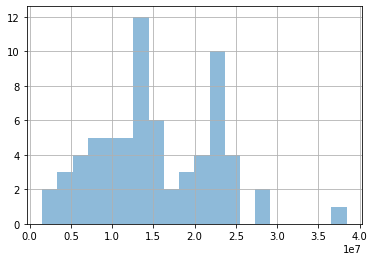

In [91]:
import matplotlib.pyplot as plt

# distribution, it's really kind of normal
data_payment['PaymentAmountUSD'].hist(bins=20,alpha = 0.5)


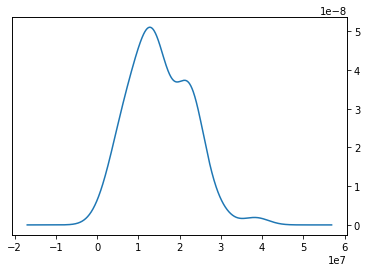

In [92]:
# kernal density
data_payment['PaymentAmountUSD'].plot(kind = 'kde', secondary_y=True) 


In [94]:
# this is to test our target model is normal distribution or not
# Perform the Shapiro-Wilk test for normality. The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.
# as p-value: 0.11315254867076874 is greater than 0.05, so we could reject the null hypothesis, so data is not normal distribution.
ss.shapiro(data_payment['PaymentAmountUSD'])

(0.9709597826004028, 0.11315254867076874)

stats result for first column:  (0.9760897755622864, 0.01017984002828598)


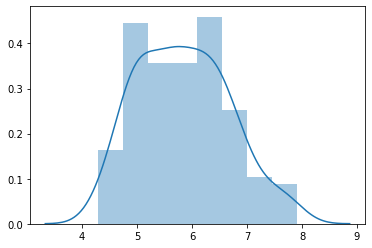

In [130]:
# if you are not famaliar with stats normal test, let's show you
from sklearn.datasets import load_iris
import seaborn as sns

x,y = load_iris(return_X_y = True)

# just focus on second value
# as p-value :  0.01017984002828598 is smaller than 0.05, so we could say we have 95% confidence to say it's a normal distribution
# in fact, it do be.
print("stats result for first column: ", ss.shapiro(x[:, 0]))

# let's plot the first col to ensure it's normal
sns.distplot(x[:, 0])
plt.show()

In [95]:
# this function is to get data different statistics value
def status(x) : #得到描述分析的结果
    return pd.Series([x.count(),x.sum(),x.min(),x.idxmin(),x.quantile(.25),x.median(),
                      x.quantile(.75),x.mean(),x.max(),x.idxmax(),x.mode(),x.mad(),x.var(),
                      x.std(),x.skew(),x.kurt()],index=['非空数','求和','最小值','最小值位置','25%分位数',
                    '中位数','75%分位数','均值','最大值','最大值位数','众数','平均绝对偏差','方差','标准差','偏度','峰度'])
 

In [99]:
info_stats = status(data_payment['PaymentAmountUSD']) 

pd.DataFrame(info_stats).T

,非空数,求和,最小值,最小值位置,25%分位数,中位数,75%分位数,均值,最大值,最大值位数,众数,平均绝对偏差,方差,标准差,偏度,峰度
0,68,1.03817e+09,1.52084e+06,56,9.66264e+06,1.40407e+07,2.14329e+07,1.52672e+07,3.84213e+07,62,0 1.520836e+06 1 2.696171e+06 2 4....,5.88699e+06,5.27761e+13,7.26472e+06,0.463759,0.211745


In [103]:
# let's get the training column
train_name = data_payment.columns.tolist()

print("Before columns: ", train_name)

# remove the first two column
train_name[:2] = ""

print("get training columns:", train_name)

Before columns:  ['PaymentAmountUSD', 'flag', 'weekofmonth_1', 'weekofmonth_3', 'weekofmonth_4', 'weekofmonth_5', 'M2M%', 'InvoiceNumber_week']
get training columns: ['weekofmonth_1', 'weekofmonth_3', 'weekofmonth_4', 'weekofmonth_5', 'M2M%', 'InvoiceNumber_week']


### Other thoughts

As I see that with target value is really big, maybe we could convert the target value with transformation like standard or log to make target with smaller range  or make target into normal distribution, so to make model to train easier.

#### TODO: why to split train and test with flag with logic

In [105]:
# let's split our training and testing data
# how to define train and test? `flag` not equal 1 will be train, otherwise will be test
# TODO: why to split train and test with flag?
xtrain = data_payment[train_name][(data_payment['flag'] != 1)]
ytrain = data_payment['PaymentAmountUSD'][(data_payment['flag'] != 1)]
xtest = data_payment[train_name][(data_payment['flag'] == 1)]
ytest = data_payment['PaymentAmountUSD'][(data_payment['flag'] == 1)]

In [107]:
# let's train our model with XGBoost, haven't done any hyper-parameters
xgbr = xgb.XGBRegressor()

model = xgbr.fit(xtrain, ytrain)

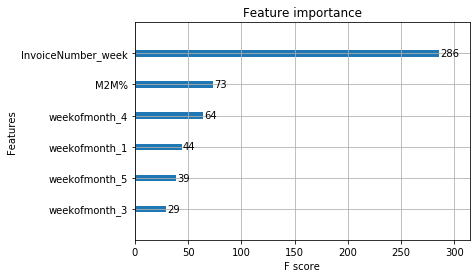

In [109]:
# plot feature importance
from xgboost.plotting import plot_importance

# so that we could get each feature contribution of each column for target.
plot_importance(model)

In [110]:
# let's get prediction
test_predict = model.predict(xtest)

# get some sample prediction
print('prediction: ', test_predict[:10])

prediction:  [10143696.   9287750.   5009468.  14487846.   2727371.5 23145526.
 14154872.  13860220.   8527068.  22732544. ]


In [111]:
# merge prediction with orginal data.
# the logic will use `stacking` logic: to add one model prediction result into another column, next model will be trained on features and rediction
# so that we could add more other info based on models, not all from humans.
data_test = data_payment[(data_payment['flag'] == 1)]
data_test['forecast'] = test_predict
data_test['forecast'] = data_test['forecast'].astype(float)

data_test.head()

,PaymentAmountUSD,flag,weekofmonth_1,weekofmonth_3,weekofmonth_4,weekofmonth_5,M2M%,InvoiceNumber_week,forecast
52,1.283905e+07,1,1,0,0,0,0.011215,1459.0,10143696.0
53,2.209209e+07,1,0,0,0,0,0.011215,2883.0,9287750.0
54,1.135771e+07,1,0,1,0,0,0.011215,1337.0,5009468.0
55,2.250334e+07,1,0,0,1,0,0.011215,2504.0,14487846.0
56,1.520836e+06,1,0,1,0,0,-0.452865,444.0,2727371.5


In [114]:
# make training data
data_train = data_payment[(data_payment['flag'] != 1)]   # get training data
data_model = data_check[['key_groupby']]  # get key

# currently with Model_Res is combined with trained and new test data by row
# Onething to notice: for training data, with `forecast` columns will be NAN
Model_Res = pd.concat([data_train, data_test], axis=0)

In [119]:
# this is to get truth data and prediction data.
Model_Res1 = Model_Res[['PaymentAmountUSD','forecast']]

# this is to get `key_groupby` index rows.
# so out will contain both train and test data.
out = data_model.join(Model_Res1)
out['forecast'] = out['forecast'].fillna(0)

print("out shape:", out.shape)

out.head()

out shape: (68, 3)


,key_groupby,PaymentAmountUSD,forecast
0,2019-1-1-1,1.097037e+07,0.0
1,2019-1-1-2,6.971815e+06,0.0
2,2019-1-1-3,4.726612e+06,0.0
3,2019-1-1-4,2.201977e+07,0.0
4,2019-1-2-1,1.281957e+07,0.0


### 根据实际聚合程度调整


In [121]:
# this is to get test columns
# to evaluate the test data.
data_test_group = out[out['forecast']>0]

# get percentage of truth and prediction difference: 1 - (truth-pred) / truth
# 
data_test_group['accuracy'] = 1-abs(data_test_group['PaymentAmountUSD']-data_test_group['forecast'])/data_test_group['PaymentAmountUSD']

# get mean value
accuracy = data_test_group['accuracy'].mean()
print('get difference:  ', accuracy)

get difference:   0.48425010371406996


In [122]:
# this is to get the difference the date not in some days
accuracy_2 = data_test_group['accuracy'][(data_test_group['key_groupby']!='2020-1-2-2')&(data_test_group['key_groupby']!='2020-1-2-3')&
                                        (data_test_group['key_groupby']!='2020-1-2-4')&(data_test_group['key_groupby']!='2020-1-3-1')].mean()

print("difference between common days: ", accuracy_2)

difference between common days:  0.5975861209366081


### added: other metrics to evaluate

In [123]:
# get test target data and prediction
test_truth = data_test_group['PaymentAmountUSD']
test_pred = data_test_group['forecast']

In [126]:
# first is RMSE
# one thing to notice: with RMSE will really based on target volumn
rmse = np.sqrt(metrics.mean_squared_error(test_truth, test_pred))

print('mean target: ', np.mean(test_truth))
print("RMSE: ", rmse)
print('ratio: ', rmse / np.mean(test_truth))

mean target:  17699288.676154375
RMSE:  10631518.8346909
ratio:  0.6006749214172866


### Noted:

Currently is for test, but in real data should consider more carefully, as we may select many other metrics to evaluate model. But with r2 is negative is not a good sigmal.

Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0. [r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

In [128]:
# let's try r2-score
# best r2-score is 1, could be negative.
r2_score = metrics.r2_score(test_truth, test_pred)

# but we find with r2 score with negative, so means model doesn't do well
print("R2 score is:", r2_score)

R2 score is: -0.4880868246229635


In [133]:
# if you are curious about how to compute r2, let's show you
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

x, y = load_boston(return_X_y=True)

lr.fit(x, y)

pred = lr.predict(x)

# r2 = 1 - sum((y-pred)**2) / sum((y - y_mean)**2)
# so for baseline model, pred will always be y_mean, so r2 is 0, if pred equal y, then r2 is 1
r2_manually = 1 - np.sum((y - pred) **2) / np.sum((y - np.mean(y)) ** 2)
r2_sklearn = metrics.r2_score(y, pred)

print('manually compute: ', r2_manually)
print('sklearn compute:  ', r2_sklearn)
assert r2_manually == r2_sklearn, 'not equal'  # if not equal will raise error

manually compute:  0.7406426641094094
sklearn compute:   0.7406426641094094


#### TODO: why not to use other feature for model training? as we have many other features. Also if we could use `stack` to train another model based on xgboost, or we could use other regression algorithms like `SVR`, `RFR`, `GBR` or even with `Deep learning`, Or even we could train many other models and combine them like `weights` of each model based on some metrics.

### Model selection

we could do parameter selection with grid-search or random-search to find best parameters.

In [129]:
"""
#存储文件
writer = pd.ExcelWriter('C://Users/fang.jia/Desktop/Project/Arrow/Model 6/【Model 6】Output-total amount.xlsx')
data_test_group.to_excel(writer, sheet_name='forecast by week')
rawdata_check_dummy.to_excel(writer, sheet_name='actual')
p_value_all.to_excel(writer, sheet_name='P_value(anove)')
corr1.to_excel(writer, sheet_name='Pearson(Correlation)')
writer.save()
'''
'''
####调参
cv_params = {'n_estimators':[100,200,300,400,500,600]}
cv_params = {'n_estimators':[70,80,90,100,120,150]}
cv_params = {'n_estimators':[30,40,50,60,70,80]}
cv_params = {'max_depth': [1,2,3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]}
cv_params = {'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7]}
cv_params = {'subsample': [0.5,0.6, 0.7, 0.8, 0.9,1], 'colsample_bytree': [0.5,0.6, 0.7, 0.8, 0.9]}
cv_params = {'reg_alpha': [0.05, 0.1, 1, 2, 3], 'reg_lambda': [0.05, 0.1, 1, 2, 3]}
cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
####找到合适参数 
#other_params = {'learning_rate': 0.1,'n_estimators': 400,'max_depth':5,'subsample': 1, 'colsample_bytree': 1, 'gamma': 0.6}
#other_params = {'n_estimators': 500,'max_depth':5, 'min_child_weight':1,'gamma': 0,'colsample_bytree': 0.8,'subsample': 0.8,
                #'reg_alpha':0,'reg_lambda':1,'learning_rate': 0.1}
other_params = {'n_estimators': 70,'max_depth':2, 'min_child_weight':6,'gamma': 0.1,'colsample_bytree': 0.8,'subsample': 0.8,
                'reg_alpha':0.1,'reg_lambda':1,'learning_rate': 0.1}
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
"""

"\n#存储文件\nwriter = pd.ExcelWriter('C://Users/fang.jia/Desktop/Project/Arrow/Model 6/【Model 6】Output-total amount.xlsx')\ndata_test_group.to_excel(writer, sheet_name='forecast by week')\nrawdata_check_dummy.to_excel(writer, sheet_name='actual')\np_value_all.to_excel(writer, sheet_name='P_value(anove)')\ncorr1.to_excel(writer, sheet_name='Pearson(Correlation)')\nwriter.save()\n'''\n'''\n####调参\ncv_params = {'n_estimators':[100,200,300,400,500,600]}\ncv_params = {'n_estimators':[70,80,90,100,120,150]}\ncv_params = {'n_estimators':[30,40,50,60,70,80]}\ncv_params = {'max_depth': [1,2,3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]}\ncv_params = {'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7]}\ncv_params = {'subsample': [0.5,0.6, 0.7, 0.8, 0.9,1], 'colsample_bytree': [0.5,0.6, 0.7, 0.8, 0.9]}\ncv_params = {'reg_alpha': [0.05, 0.1, 1, 2, 3], 'reg_lambda': [0.05, 0.1, 1, 2, 3]}\ncv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}\n####找到合适参数 \n#other_params = {'learning_r